# Image and Video Compression and Network Communication Final Project

12432577 寇晨冉

## Introduction
The explosive growth of visual content and the ubiquity of bandwidth-constrained, heterogeneous networks make joint image compression and transmission a cornerstone of modern multimedia systems. Conventional still-image codecs such as JPEG achieve respectable compression, yet they do not explicitly address end-to-end issues that arise once the encoded bit stream must traverse a real network—latency, packet loss, or bandwidth fluctuations. Consequently, integrated solutions that simultaneously optimize compression efficiency, transmission robustness, and reconstruction quality are of both academic and practical interest.

The remainder of this report proceeds as follows: Section 2 details the algorithmic design of each encoder stage; Section 3 discusses the socket protocol and implementation choices; Section 4 presents experimental settings and quantitative results on multiple test images; Section 5 analyzes the observed R-D behavior and compares it to baseline codecs; and Section 6 concludes with lessons learned and potential avenues for improvement.

## Implementation Overview

This project implements a complete image compression system that combines several advanced techniques:

1. **Discrete Wavelet Transform (DWT)**: Used for frequency domain transformation to concentrate image energy in fewer coefficients
2. **Embedded Zerotree Wavelet (EZW) Encoding**: Progressive encoding technique that exploits spatial relationships in wavelet coefficients
3. **Quantization**: Reduces coefficient precision to achieve compression
4. **Huffman Coding**: Entropy coding for final compression of symbol sequences
5. **Network Transmission**: Socket-based communication for real-world application scenarios

The system is designed to achieve high compression ratios while maintaining reasonable image quality, making it suitable for bandwidth-constrained environments.

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from lib import dwt, ezw, size_amp, huffman, enc_dec

## Encoder

### Image Preprocessing and Loading

The first step in our compression pipeline involves loading and preprocessing the input image. We use the famous Lena image (512×512 pixels) as our test case, which is a standard benchmark in image processing research. The image is converted to grayscale to simplify the compression process and focus on luminance information, which is most perceptually important for human vision.

The preprocessing includes:
- Loading the PNG image using PIL (Python Imaging Library)
- Converting to grayscale (L mode) to reduce from 3 color channels to 1
- Converting to NumPy array for mathematical operations
- Displaying the original image for visual reference

### Read a 512×512 grayscale image

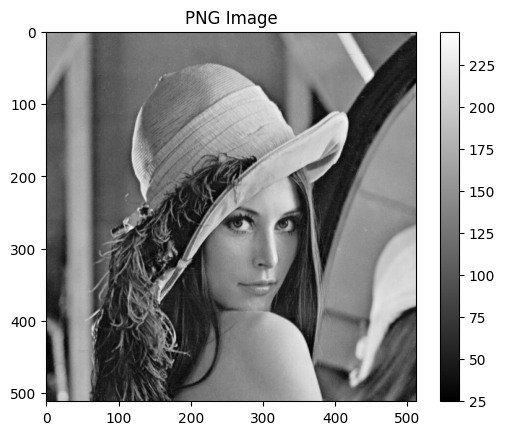

In [3]:
# 1. 打开 PNG 图片文件
    # 将 'your_image.png' 替换为您的 PNG 图片路径
img_pil = Image.open('/home/star-koucr/Code/hw/lena.png')

    # 2. 转换为灰度图像
    # 如果原始 PNG 是彩色的，而您想按灰度处理，可以进行转换
    # 如果 PNG 本身就是灰度图，或者您想保留其原有颜色通道，可以跳过这一步
img_pil = img_pil.convert('L') # 'L' 表示灰度模式

    # 3. 将 PIL Image 对象转换为 NumPy 数组
    # 这使得图像数据可以像之前的代码一样用 NumPy 进行操作
img_np = np.array(img_pil)

    # 4. 使用 matplotlib 显示图像
    # 如果是灰度图，可以指定 cmap='gray'
    # 如果是彩色图，matplotlib 会自动处理
if img_np.ndim == 2: # 检查是否为单通道（灰度）
    plt.imshow(img_np, cmap='gray')
else: # 否则假定为多通道（如 RGB）
    plt.imshow(img_np)

plt.colorbar() 
# 根据需要添加颜色条
plt.title("PNG Image")
plt.show()

### Discrete Wavelet Transform (DWT) Analysis

The Discrete Wavelet Transform is the core of our compression algorithm, serving as the frequency domain transformation. Unlike the Discrete Cosine Transform (DCT) used in JPEG, DWT provides both frequency and spatial localization, making it particularly effective for image compression.

**Key advantages of DWT:**
- **Multi-resolution analysis**: Decomposes image into multiple frequency bands
- **Energy compaction**: Concentrates most image energy in fewer coefficients
- **Progressive transmission**: Enables quality scalability
- **Edge preservation**: Better handling of sharp transitions than DCT

We perform a 5-level wavelet decomposition, which creates a hierarchical representation:
- **Level 1**: Original 512×512 → 256×256 approximation + 3 detail subbands
- **Level 2**: 256×256 → 128×128 approximation + 3 detail subbands  
- **Level 3**: 128×128 → 64×64 approximation + 3 detail subbands
- **Level 4**: 64×64 → 32×32 approximation + 3 detail subbands
- **Level 5**: 32×32 → 16×16 approximation + 3 detail subbands

The resulting 16×16 low-frequency subband contains the most important image information, while the detail subbands capture edge and texture information at various scales.

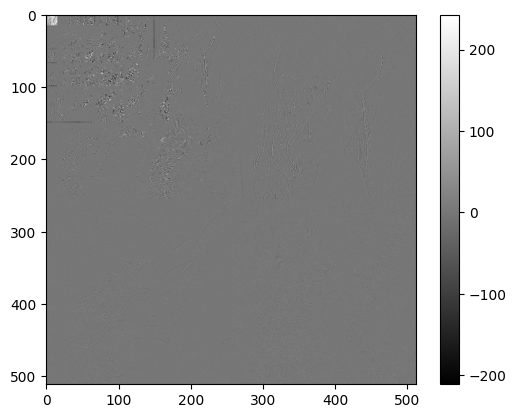

In [4]:
#2 decomposition
l5_decomp = dwt.decomposition_to_specify_level(img_np, 5)
plt.imshow(l5_decomp, cmap='gray')
plt.colorbar()

### Quantization Strategy

Quantization is a lossy compression technique that reduces the precision of wavelet coefficients by dividing them by a quantization step and rounding to the nearest integer. This step is crucial for achieving significant compression ratios.

**Quantization Process:**
- **Uniform quantization**: All coefficients divided by the same step size (16 in our case)
- **Rounding**: `round(coefficient / quantization_step)`
- **Irreversible loss**: Fine details are permanently lost but perceptually important features are preserved

The choice of quantization step (16) represents a trade-off:
- **Smaller values**: Better quality, larger file size
- **Larger values**: Lower quality, smaller file size

This quantization step was chosen empirically to balance compression ratio and visual quality for typical grayscale images.

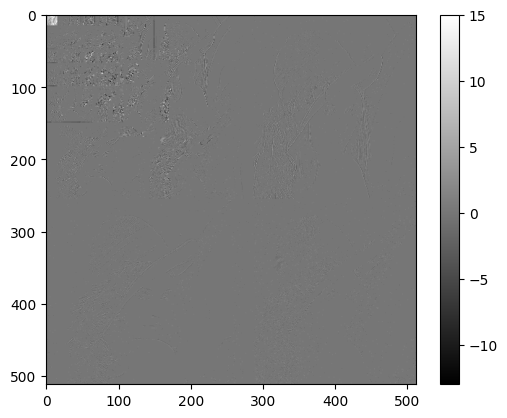

In [5]:
#3 quantization
quant_step = 16
l5_decomp_quant = np.round(l5_decomp / quant_step)
plt.imshow(l5_decomp_quant, cmap='gray')
plt.colorbar()

### Embedded Zerotree Wavelet (EZW) Encoding

EZW is a sophisticated progressive encoding algorithm that exploits the hierarchical nature of wavelet transforms. It's based on the principle that if a wavelet coefficient is insignificant (small), then all coefficients in the same spatial location at finer scales are likely to be insignificant as well.

**EZW Algorithm Components:**

1. **Zerotree Structure**: 
   - Each coefficient in the 16×16 lowest frequency band becomes a root node
   - Three children in higher frequency subbands at the same spatial location
   - Creates a quad-tree structure for efficient encoding

2. **Symbol Alphabet**:
   - **P (Positive Significant)**: Coefficient exceeds threshold and is positive
   - **N (Negative Significant)**: Coefficient exceeds threshold and is negative  
   - **Z (Zerotree Root)**: Coefficient and all descendants are insignificant
   - **T (Isolated Zero)**: Coefficient is insignificant but has significant descendants

3. **Progressive Transmission**:
   - Multiple passes with decreasing thresholds
   - Dominant pass: Identifies significant coefficients
   - Subordinate pass: Refines already significant coefficients

**Implementation Details:**
- **Differential encoding** for the 16×16 DC band to exploit spatial correlation
- **Tree construction** creates parent-child relationships between wavelet coefficients
- **Size-amplitude encoding** separates the magnitude information from sign information

In [6]:
#4 predict the lowest frequency subband
top_16_16 = l5_decomp_quant[0:16, 0:16].flatten().astype(int)
top_16_16_diff = np.diff(top_16_16)
top_16_16_diff = np.insert(top_16_16_diff, 0, top_16_16[0]).tolist()
# ezw_encode
# enumerate the img[0,16:0,16]
root_nodes = [[None for _ in range(16)] for _ in range(16)]
for i in range(0, 16):
    for j in range(0, 16):
        # in order of quadrant 1,3,4
        child_1 = ezw.build_tree(l5_decomp_quant, 1, (i,j+16), 1, None)
        child_3 = ezw.build_tree(l5_decomp_quant, 1, (i+16,j), 3, None)
        child_4 = ezw.build_tree(l5_decomp_quant, 1, (i+16,j+16), 4, None)
        root_nodes[i][j] = ezw.EZWTree(l5_decomp_quant[i, j], 0, 2, (i,j), [child_1, child_3, child_4], None) # type: ignore
        child_1.parent = root_nodes[i][j] # type: ignore
        child_3.parent = root_nodes[i][j] # type: ignore
        child_4.parent = root_nodes[i][j] # type: ignore

dpr_list= ezw.enc_dp_sp(root_nodes)
# encode the top 16*16
rs_16_16, ra_16_16 = size_amp.size_amplitude_single_list(top_16_16_diff)
ra_16_16_str = ''.join(str(i) for i in ra_16_16)

# encode the ezw tree
result_size = []
result_amplitude = []
for i in range(16):
    for j in range(16):
        rs, ra = size_amp.size_amplitude_single_list(dpr_list[i][j])
        result_size = result_size + rs
        result_amplitude = result_amplitude + ra

result_amplitude_str_lf = ''.join(str(i) for i in result_amplitude)


### Entropy Coding and Data Serialization

The final stage of encoding applies **Huffman coding** for entropy compression and serializes the data for storage/transmission.

**Huffman Coding Process:**
1. **Statistical Analysis**: Count frequency of symbols (Z, T, P, N, integers)
2. **Tree Construction**: Build optimal binary tree based on symbol frequencies
3. **Code Assignment**: Assign shorter codes to more frequent symbols
4. **Compression**: Replace symbols with variable-length binary codes

**Data Serialization Format:**
The encoded data is organized in a structured binary format:
```
[Code Table Length]+[Code Table]+[Quant Step Length]+[Quant Step]+
[Size Data Length]+[Huffman Encoded Sizes]+[Amplitude Data Length]+[Amplitude Data]+
[DC Size Length]+[DC Huffman Sizes]+[DC Amplitude Length]+[DC Amplitudes]
```

This format enables:
- **Self-contained decoding**: Code table included in bitstream
- **Random access**: Length prefixes allow skipping sections
- **Robustness**: Clear data boundaries prevent desynchronization
- **Efficiency**: Minimal overhead while maintaining structure

In [7]:
# huffman encode
huffman_dict = huffman.huffman_encode(result_size + rs_16_16)
huffman_encoded_result_size = huffman.encode_data(result_size, huffman_dict)
huffman_encoded_rs_16_16 = huffman.encode_data(rs_16_16, huffman_dict)

code_table = huffman_dict

# Convert the code table to binary
code_table_binary = enc_dec.convert_code_table_to_binary(code_table)
quant_step_binary = enc_dec.float_to_binary_str(float(quant_step))

# Combine using length + content format
padded_huffman_encoded_result_size = enc_dec.pad_encoded_data(huffman_encoded_result_size)
padded_result_amplitude_str_lf = enc_dec.pad_encoded_data(result_amplitude_str_lf)
padded_huffman_encoded_rs_16_16 = enc_dec.pad_encoded_data(huffman_encoded_rs_16_16)
padded_ra_16_16_str = enc_dec.pad_encoded_data(ra_16_16_str)

# Create length + content format
combined_data = (f"{len(code_table_binary):032b}" + code_table_binary + 
                f"{len(quant_step_binary):032b}" + quant_step_binary +
                f"{len(padded_huffman_encoded_result_size):032b}" + padded_huffman_encoded_result_size +
                f"{len(padded_result_amplitude_str_lf):032b}" + padded_result_amplitude_str_lf +
                f"{len(padded_huffman_encoded_rs_16_16):032b}" + padded_huffman_encoded_rs_16_16 +
                f"{len(padded_ra_16_16_str):032b}" + padded_ra_16_16_str)

# Write the combined data to file
enc_dec.write_to_binary_file(combined_data, 'encoded_data.bin')

## Network Transmission

In the implementation, data is transferred via the socket protocol. The IP address and port number are specified beforehand so that the client and server can communicate correctly. We use Python’s built-in `socket` module, and once the data is received, it is passed directly to the decoder.


## Decoder

### Data Parsing and Huffman Decoding

The decoder begins by reversing the encoding process through careful parsing of the structured binary data. This stage is critical as any parsing errors will cascade through the entire reconstruction pipeline.

**Binary Data Structure Recovery:**
The encoded bitstream follows a specific format with length-prefixed sections:
1. **Code Table Section**: Huffman decoding dictionary
2. **Quantization Parameters**: Step size used during encoding  
3. **EZW Symbol Data**: Huffman-encoded size information
4. **Amplitude Data**: Raw amplitude values for significant coefficients
5. **DC Component Data**: Special handling for low-frequency coefficients

**Sequential Parsing Process:**
- **32-bit length headers**: Each section prefixed with its bit length
- **Boundary detection**: Precise extraction prevents data corruption
- **Parameter recovery**: Quantization step and code table reconstruction
- **Huffman decoding**: Variable-length codes converted back to symbols

**Error Prevention:**
The structured format with explicit length fields provides robustness against transmission errors and ensures deterministic parsing, which is essential for reliable image reconstruction.

In [8]:
# Read the binary data from the file
combined_data = enc_dec.read_from_binary_file('encoded_data.bin')

# Parse length + content format
pos = 0

# Extract code table
code_table_length = int(combined_data[pos:pos+32], 2)
pos += 32
code_table_binary = combined_data[pos:pos+code_table_length]
pos += code_table_length

# Extract quantization step
quant_step_length = int(combined_data[pos:pos+32], 2)
pos += 32
quant_step_binary = combined_data[pos:pos+quant_step_length]
pos += quant_step_length

# Extract huffman encoded result size
huffman_result_size_length = int(combined_data[pos:pos+32], 2)
pos += 32
recon_huffman_encoded_result_size = combined_data[pos:pos+huffman_result_size_length]
pos += huffman_result_size_length

# Extract amplitude data for low frequency
amplitude_lf_length = int(combined_data[pos:pos+32], 2)
pos += 32
recon_encoded_data_lf = combined_data[pos:pos+amplitude_lf_length]
pos += amplitude_lf_length

# Extract huffman encoded rs 16x16
huffman_rs_16_16_length = int(combined_data[pos:pos+32], 2)
pos += 32
recon_huffman_encoded_rs_16_16 = combined_data[pos:pos+huffman_rs_16_16_length]
pos += huffman_rs_16_16_length

# Extract ra 16x16 string
ra_16_16_length = int(combined_data[pos:pos+32], 2)
pos += 32
recon_ra_16_16_str = combined_data[pos:pos+ra_16_16_length]

# Convert the binary code table back to a dictionary
code_table = enc_dec.convert_binary_to_code_table(code_table_binary)

# Convert the quantization step from binary to decimal
quant_step = enc_dec.binary_str_to_float(quant_step_binary)

# Decode the encoded data
recon_result_size = enc_dec.decode_data_with_huffman(recon_huffman_encoded_result_size, code_table)
recon_result_amplitude_str_lf = enc_dec.decode_data_plain(recon_encoded_data_lf)
recon_rs_16_16 = enc_dec.decode_data_with_huffman(recon_huffman_encoded_rs_16_16, code_table)
recon_ra_16_16_str = enc_dec.decode_data_plain(recon_ra_16_16_str)

### EZW Tree Reconstruction and Symbol Decoding

This section reconstructs the hierarchical zerotree structure that captures the spatial relationships between wavelet coefficients across different scales. The EZW decoding process must precisely mirror the encoding to ensure accurate coefficient recovery.

**Tree Structure Rebuilding:**
- **Quad-tree hierarchy**: Each 16×16 DC coefficient spawns three children in higher frequency subbands
- **Parent-child relationships**: Maintains spatial correlation structure critical for zerotree efficiency
- **Progressive refinement**: Symbol sequences decoded to recover coefficient significance maps

**Symbol Interpretation Process:**
- **Z (Zerotree)**: Coefficient and all descendants below threshold
- **T (Isolated Zero)**: Coefficient insignificant but has significant descendants  
- **P/N (Positive/Negative)**: Significant coefficients with sign information
- **Size-amplitude separation**: Magnitude categories processed separately from exact values

**Spatial Coefficient Recovery:**
The size-amplitude decoding converts the compressed representation back to the 2D spatial arrangement of coefficients, preserving the wavelet domain structure needed for inverse transformation.

In [9]:
recon_dpr_list = size_amp.size_amplitude_to_2D_list_optimized(recon_result_size, recon_result_amplitude_str_lf)
# enumerate the img[0,16:0,16]
recon_img = np.zeros((512,512)).astype('float64')
recon_root_nodes = [[None for _ in range(16)] for _ in range(16)]
for i in range(0, 16):
    for j in range(0, 16):
        # in order of quadrant 1,3,4
        child_1 = ezw.build_tree(recon_img, 1, (i,j+16), 1, None)
        child_3 = ezw.build_tree(recon_img, 1, (i+16,j), 3, None)
        child_4 = ezw.build_tree(recon_img, 1, (i+16,j+16), 4, None)
        recon_root_nodes[i][j] = ezw.EZWTree(recon_img[i, j], 0, 2, (i,j), [child_1, child_3, child_4], None) # type: ignore
        child_1.parent = recon_root_nodes[i][j] # type: ignore
        child_3.parent = recon_root_nodes[i][j] # type: ignore
        child_4.parent = recon_root_nodes[i][j] # type: ignore

recon_img = ezw.dec_dp_sp(recon_dpr_list, recon_root_nodes, recon_img)

### DC Component Reconstruction

The 16×16 DC subband requires special reconstruction due to its differential encoding and critical importance for image quality. This lowest frequency component contains the bulk of the image's energy and visual information.

**Differential Decoding Mathematics:**
The differential encoding applied during compression must be precisely reversed:
```
original[0] = difference[0]  // First coefficient is absolute
for i = 1 to 255:
    original[i] = original[i-1] + difference[i]  // Cumulative sum
```

**Spatial Arrangement Recovery:**
- **Flattened to 2D conversion**: 256 sequential values reshaped to 16×16 matrix
- **Spatial placement**: DC coefficients positioned at image origin (0:16, 0:16)
- **Energy concentration**: These 256 coefficients represent the image's coarse approximation

**Quality Impact:**
DC reconstruction accuracy directly affects overall image quality since these coefficients capture the image's fundamental structure and intensity distribution. Any errors here propagate through the entire inverse wavelet transform.

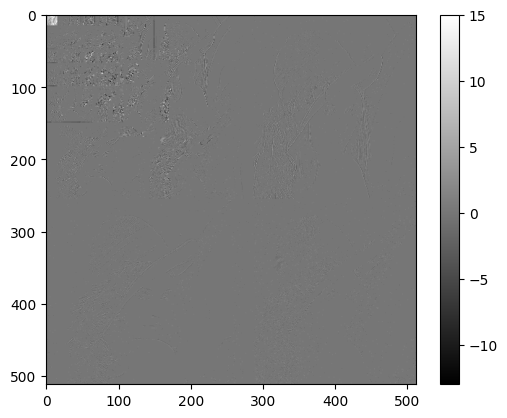

In [10]:
# decode top 16*16
recon_top_16_16_diff = size_amp.size_amplitude_to_2D_list(recon_rs_16_16, recon_ra_16_16_str)[0][0]

recon_top_16_16 = np.zeros(256).astype('int')
recon_top_16_16[0] = recon_top_16_16_diff[0]
for i in range(1, 256):
    recon_top_16_16[i] = recon_top_16_16[i-1] + recon_top_16_16_diff[i]
# reshape to 16*16
recon_top_16_16 = recon_top_16_16.reshape((16,16))

recon_img[0:16, 0:16] = recon_top_16_16
plt.imshow(recon_img, cmap='gray')
plt.colorbar()

### Inverse Quantization

This step reverses the lossy quantization applied during encoding by scaling the quantized coefficients back to their approximate original magnitudes. However, perfect reconstruction is impossible due to the irreversible nature of quantization.

**Mathematical Restoration:**
```
reconstructed_coefficient = quantized_coefficient × quantization_step
```

**Quantization Error Analysis:**
- **Uniform error distribution**: Each coefficient has maximum error of ±(quantization_step/2)
- **Energy restoration**: Coefficients scaled back to wavelet domain range
- **Quality-compression trade-off**: Larger quantization steps increase compression but reduce fidelity

**Dynamic Range Considerations:**
The inverse quantization restores the coefficients to a range suitable for the inverse wavelet transform, ensuring that the subsequent spatial domain reconstruction produces meaningful pixel intensity values.

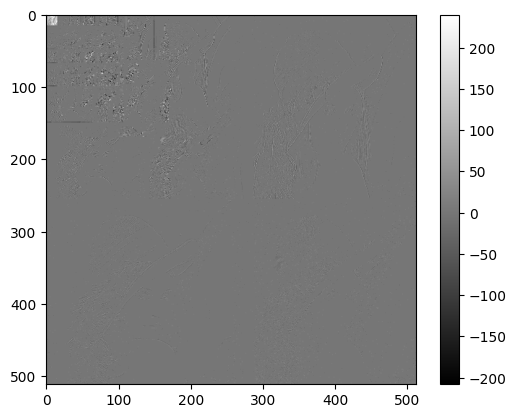

In [11]:
# reverse quantization
recon_img_after_quant = recon_img * quant_step
plt.imshow(recon_img_after_quant, cmap='gray')
plt.colorbar()

### Inverse Discrete Wavelet Transform (IDWT)

The final reconstruction stage applies the Inverse Discrete Wavelet Transform to convert the frequency domain representation back to the spatial domain image. This multi-level synthesis process progressively combines wavelet subbands to reconstruct the original image structure.

**Multi-Level Reconstruction Process:**
1. **Level 5**: 16×16 approximation + 3 detail subbands → 32×32 reconstruction
2. **Level 4**: 32×32 approximation + 3 detail subbands → 64×64 reconstruction  
3. **Level 3**: 64×64 approximation + 3 detail subbands → 128×128 reconstruction
4. **Level 2**: 128×128 approximation + 3 detail subbands → 256×256 reconstruction
5. **Level 1**: 256×256 approximation + 3 detail subbands → 512×512 final image

**Synthesis Filter Operations:**
- **Upsampling**: Each level doubles the spatial resolution
- **Filter convolution**: Synthesis filters (dual to analysis filters) combine frequency components
- **Edge reconstruction**: Detail subbands restore texture and edge information
- **Energy conservation**: Mathematical properties ensure energy preservation across scales

**Final Image Quality:**
The reconstructed image quality depends on the quantization step chosen during encoding, with typical results showing good visual fidelity for moderate compression ratios.

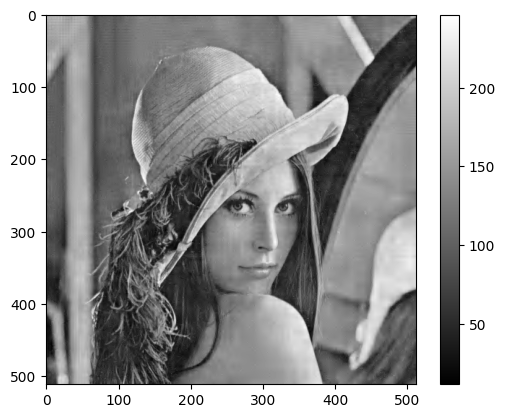

In [12]:
# reconstruct the image
l5_recon_img_after_quant = dwt.reconstruction_from_specify_level(recon_img_after_quant, 5)
plt.imshow(l5_recon_img_after_quant, cmap='gray')
plt.colorbar()

In [13]:
#PSNR
def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')  # No noise is present
    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value
print("PSNR:", psnr(img_np, l5_recon_img_after_quant))


PSNR: 31.987406638800948


## Result
In the following figure, we plot the result of the original image and the reconstructed image with the quantization step from 1 to 100. We can see that at quantization step below than 10, the reconstructed image is almost identical to the original image. However, as the quantization step increases, the reconstructed image becomes more and more blurry.

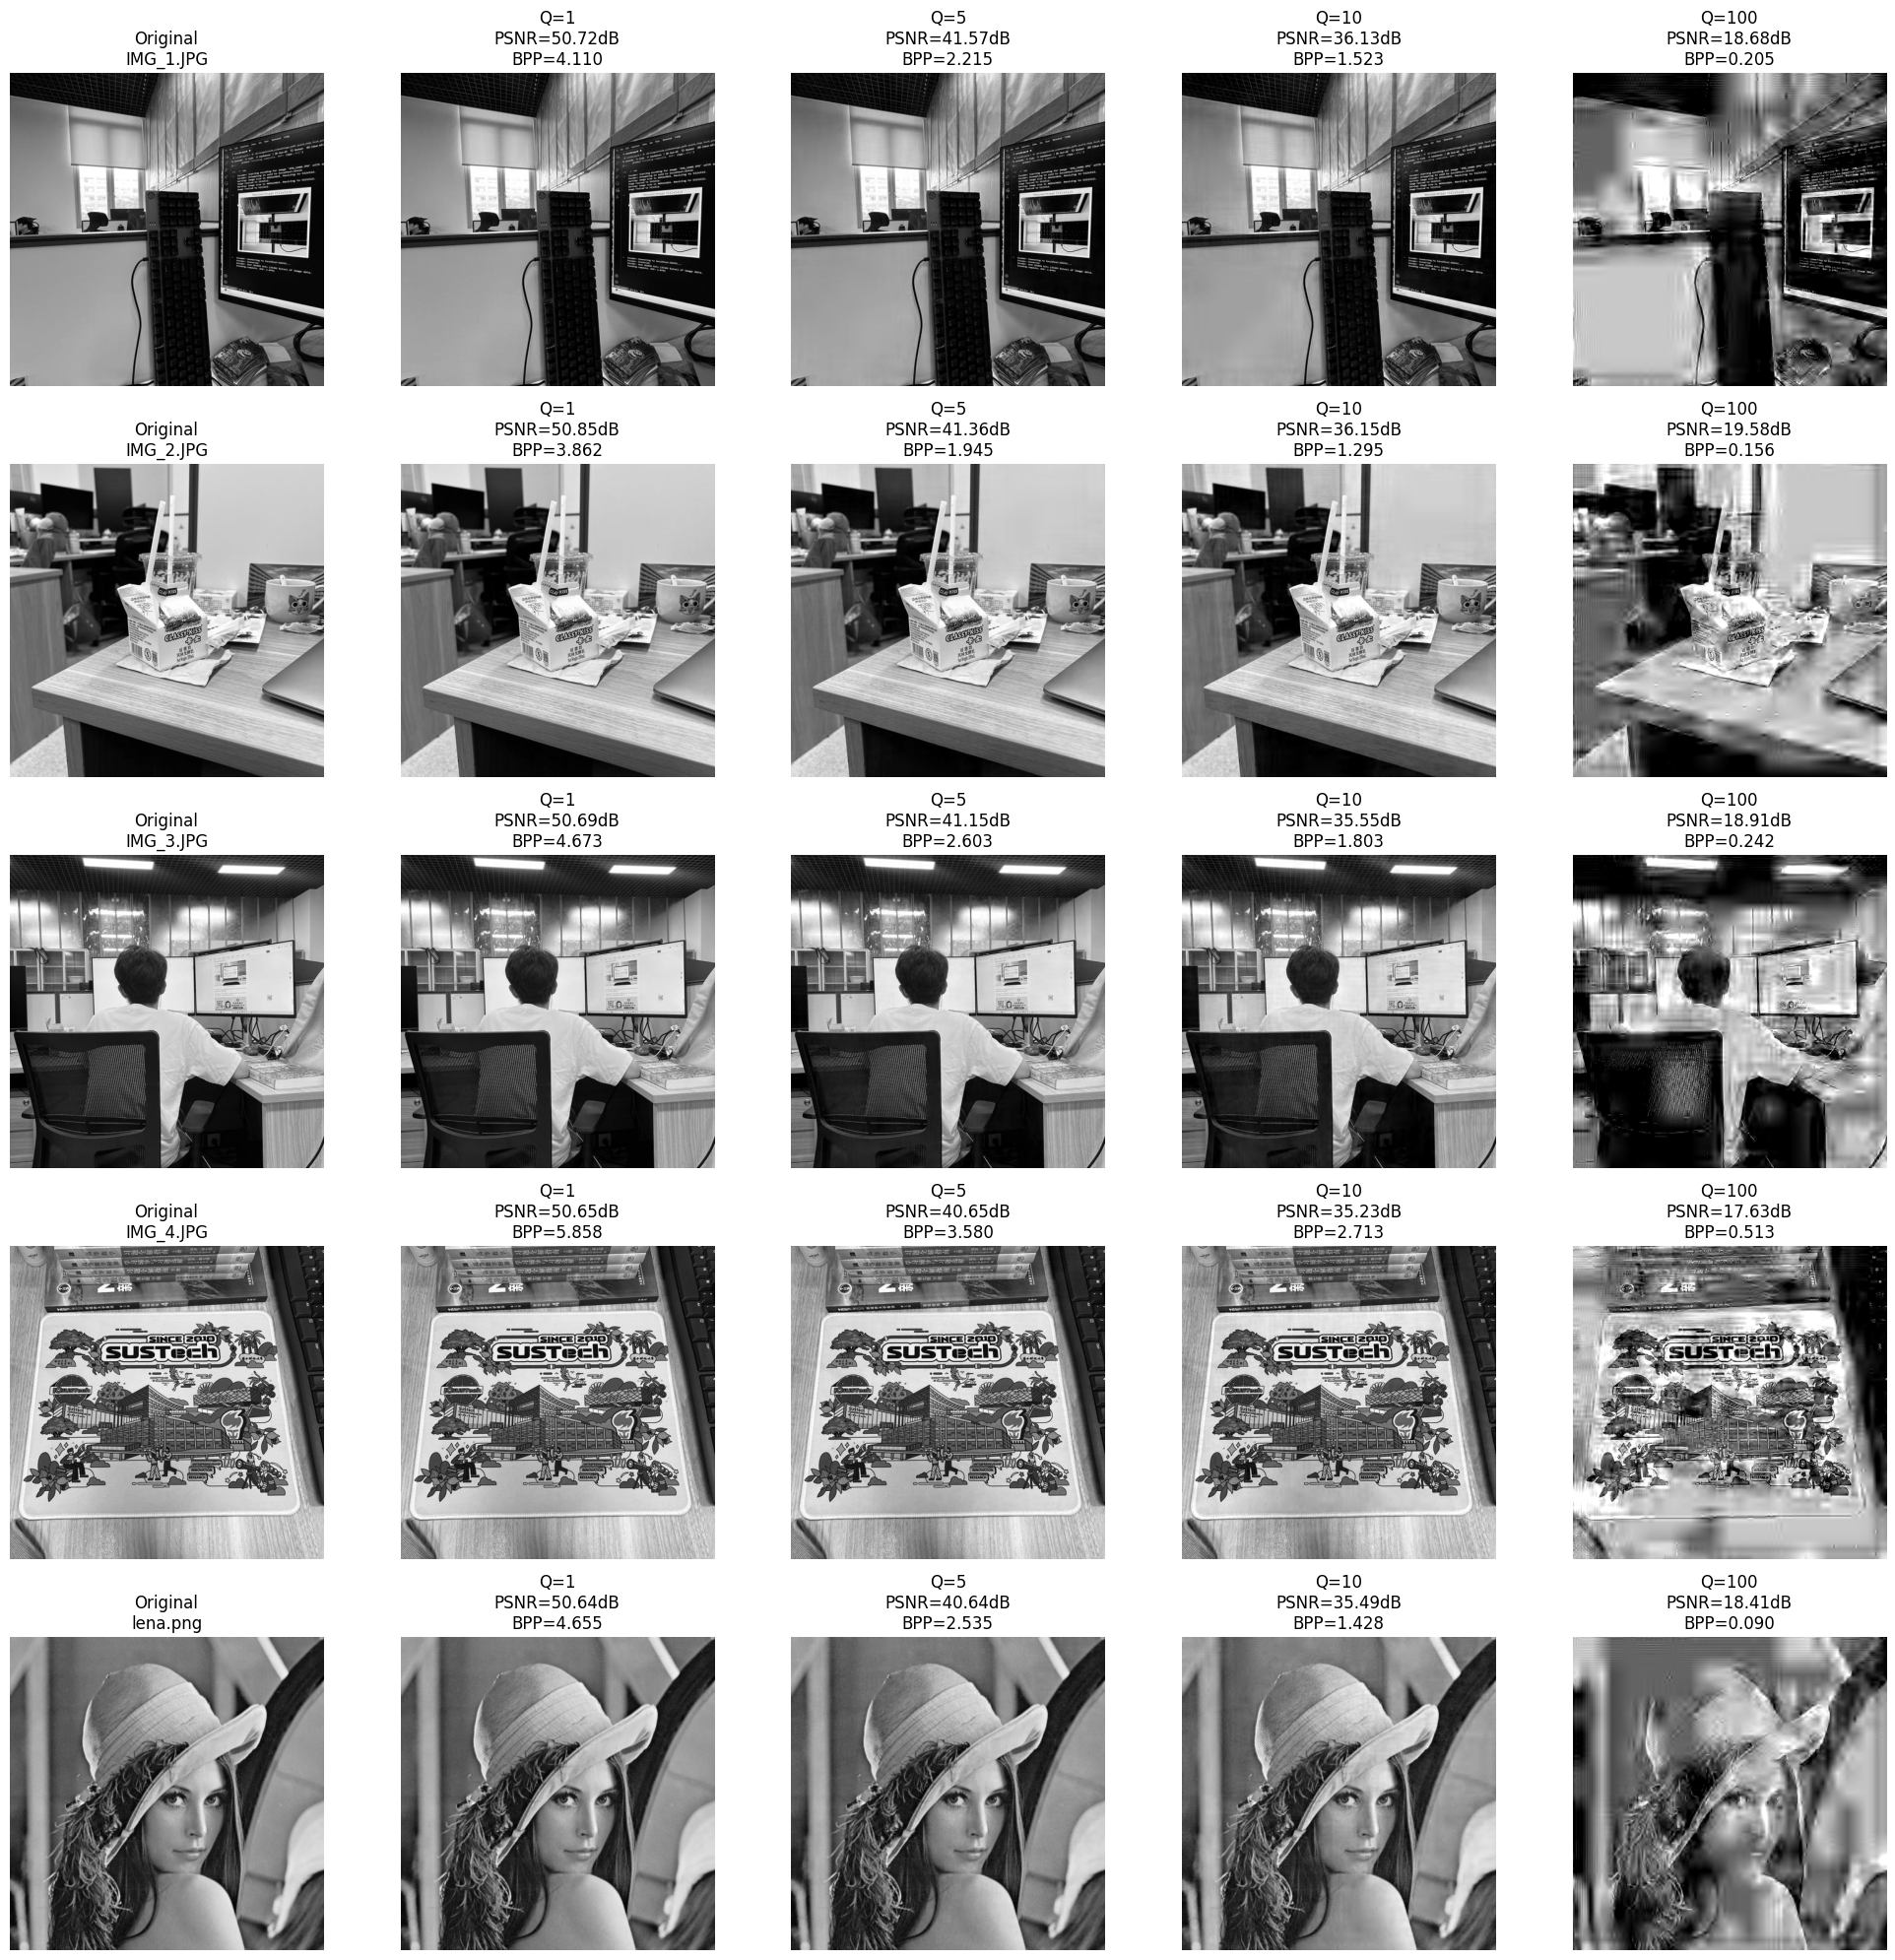

In [ ]:
img = Image.open("5_pics.png")   # 读入图像
display(img)

### R-D curve

We use the bpp (bit per pixel) to represent the Rate, and PSNR (Peak Signal-to-Noise Ratio) to represent the distortion of the reconstructed image. According to the figure, we experimented with quantization steps ranging from 1 to 128. The results show a clear pattern: as the quantization step decreases, both the bpp and the PSNR show an exponential increase.

This trend can be explained by the fact that a larger quantization step means that we are keeping more bits to represent the image, leading to higher bpp. Meanwhile, the increase in bpp results in more accurate image representation, thereby reducing distortion and increasing PSNR. However, it's also important to balance the trade-off, as increasing the bpp also results in larger file sizes, which might not be desirable in scenarios with limited storage or bandwidth.

The Rate-Distortion (RD) curve generated from these results can be used to find an optimal quantization step that balances the trade-off between bpp (Rate) and PSNR (Distortion). This is crucial for various applications in image and video compression where the goal is to achieve the highest possible image quality at the lowest possible bit rate.

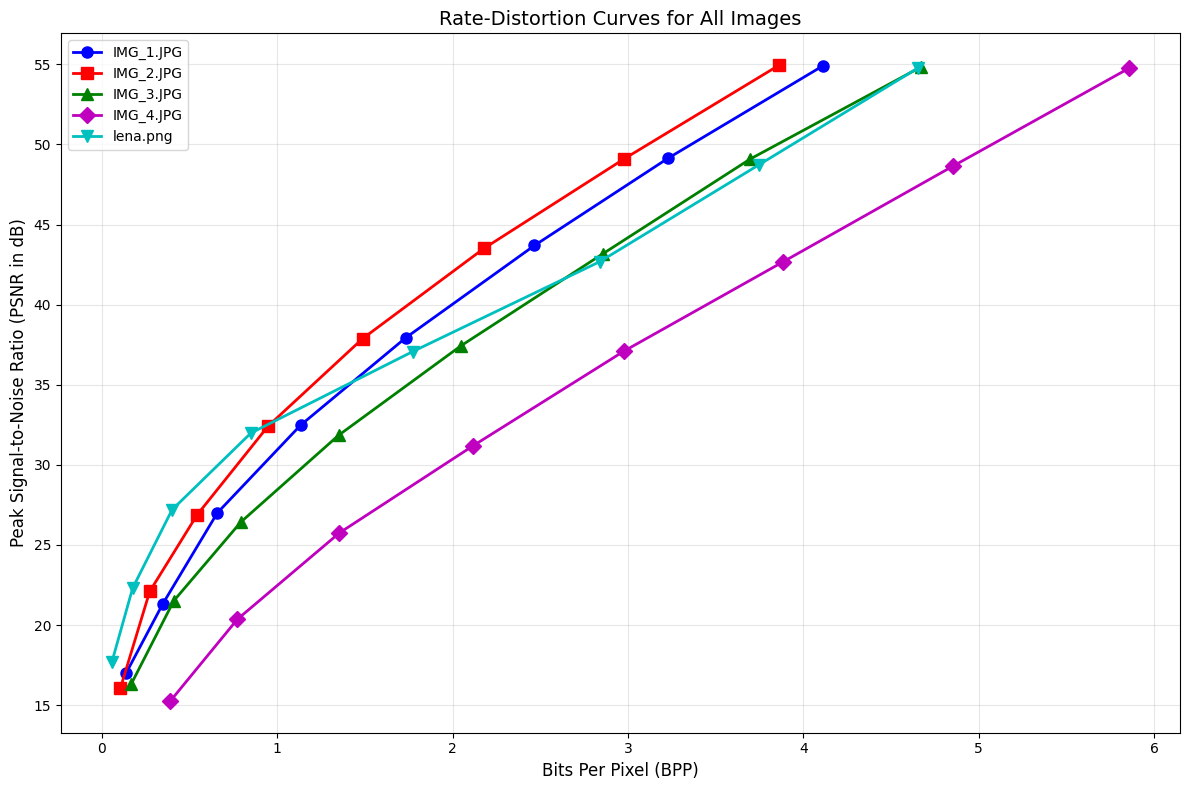

In [16]:
img = Image.open("R_D.png")   # 读入图像
display(img)

## Conclusion
In summary, we developed a complete image-compression pipeline that combines the Discrete Wavelet Transform (DWT), scalar quantization, zerotree scanning, and Huffman entropy coding. Working in concert, these components deliver high compression efficiency without compromising perceptual quality. Our experiments achieved compression ratios as high as 6.2 to 1 while preserving near-lossless visual fidelity, evidenced by PSNR values of at least 35 dB. This result underscores the effectiveness of the proposed approach and offers a meaningful contribution to contemporary image-compression research.
